In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dir_anh = 'img/xquang5.jpg'

In [3]:
# Hàm tự viết cho Histogram Equalization toàn cục
def histogram_equalization(hinh_anh):
    # Tính tần suất của mỗi mức xám
    kich_thuoc_anh = hinh_anh.shape[0] * hinh_anh.shape[1]
    muc_sang_max = max(hinh_anh.flatten())
    freqs_muc_xam = np.zeros(256, dtype=int)

    for i in range(hinh_anh.shape[0]):
        for j in range(hinh_anh.shape[1]):
            freqs_muc_xam[hinh_anh[i, j]] += 1
    freqs_muc_xam = freqs_muc_xam/kich_thuoc_anh 
    
    # Tính CDF
    cdf = np.cumsum(freqs_muc_xam)
    
    # Tính giá trị mới cho các mức xám 
    muc_sang_moi = np.round(muc_sang_max*cdf).astype(np.uint8)
    
    # Áp dụng mapping lên ảnh
    can_bang = np.zeros_like(hinh_anh)
    for i in range(hinh_anh.shape[0]):
        for j in range(hinh_anh.shape[1]):
            can_bang[i, j] = muc_sang_moi[hinh_anh[i, j]]
    
    return can_bang

In [6]:
h_anh = cv2.imread(dir_anh, 0)
hist_origin = h_anh.ravel()

h_anh_can_bang1 = histogram_equalization(h_anh)
hist_can_bang1 = h_anh_can_bang1.ravel()

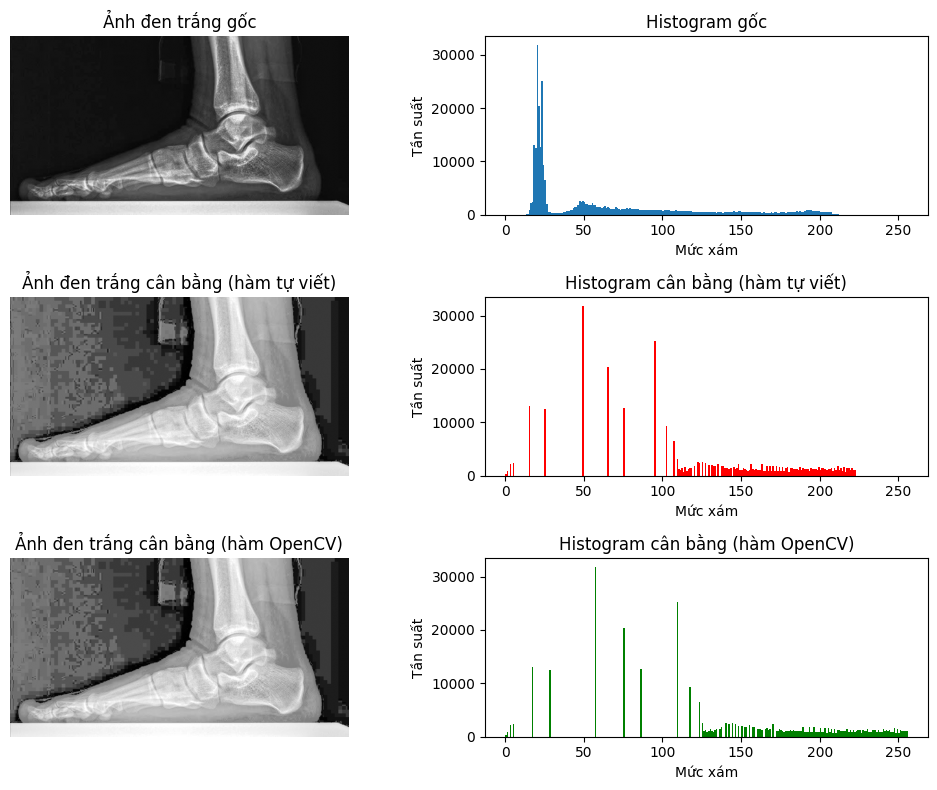

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8))

# Vẽ ảnh gốc và histogram gốc
ax[0, 0].imshow(h_anh, cmap='gray')
ax[0, 0].set(title='Ảnh đen trắng gốc')
ax[0, 0].axis('off')

ax[0, 1].hist(hist_origin, bins=256, range=(0, 256))
ax[0, 1].set(title='Histogram gốc', xlabel='Mức xám', ylabel='Tần suất')

# Vẽ ảnh cân bằng và histogram cân bằng(hàm tự viết)
ax[1, 0].imshow(h_anh_can_bang1, cmap='gray')
ax[1, 0].set(title='Ảnh đen trắng cân bằng (hàm tự viết)')
ax[1, 0].axis('off')

ax[1, 1].hist(hist_can_bang1, bins=256, range=(0, 256), color='red')
ax[1, 1].set(title='Histogram cân bằng (hàm tự viết)', xlabel='Mức xám', ylabel='Tần suất')

# Vẽ ảnh và histogram cân bằng (hàm OpenCV)
ax[2, 0].imshow(cv2.equalizeHist(h_anh), cmap='gray')
ax[2, 0].set(title='Ảnh đen trắng cân bằng (hàm OpenCV)')
ax[2, 0].axis('off')

ax[2, 1].hist(cv2.equalizeHist(h_anh).ravel(), bins=256, range=(0, 256), color='green')
ax[2, 1].set(title='Histogram cân bằng (hàm OpenCV)', xlabel='Mức xám', ylabel='Tần suất')

plt.tight_layout()
plt.show();

In [12]:
def pad_image_for_tiling(image, grid_size):
    height, width = image.shape
    grid_rows, grid_cols = grid_size
        
    # Tính kích thước cần thiết để chia hết
    target_height = ((height + grid_rows - 1) // grid_rows) * grid_rows  # Ceiling division
    target_width = ((width + grid_cols - 1) // grid_cols) * grid_cols
    
    # Tính padding cần thiết
    pad_height = target_height - height
    pad_width = target_width - width
    
    
    # Chỉ pad nếu cần thiết
    if pad_height > 0 or pad_width > 0:
        # Phân phối padding đều cho các cạnh
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left
        
        
        # Áp dụng padding (symmetric hoặc reflect thường tốt hơn constant)
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='reflect')
        
        # Lưu thông tin để crop lại sau
        pad_info = {
            'original_shape': (height, width),
            'pad_top': pad_top,
            'pad_bottom': pad_bottom,
            'pad_left': pad_left,
            'pad_right': pad_right
        }
    else:
        padded_image = image.copy()
        pad_info = {'original_shape': (height, width)}
  
    
    return padded_image, pad_info

In [13]:
def crop_padded_result(padded_result, pad_info):
    original_height, original_width = pad_info['original_shape']
    
    if 'pad_top' in pad_info:
        pad_top = pad_info['pad_top']
        pad_left = pad_info['pad_left']
        
        # Crop về kích thước gốc
        result = padded_result[pad_top:pad_top + original_height, 
                              pad_left:pad_left + original_width]
    else:
        result = padded_result
    
    return result

In [14]:
def compute_histogram(tile):
    hist = np.zeros(256, dtype=np.int32)
    for pixel in tile.flatten():
        hist[pixel] += 1
    return hist

In [15]:
def create_lookup_table(hist):
    cdf = np.cumsum(hist)
    if cdf[-1] > 0:
        cdf_normalized = (cdf * 255.0 / cdf[-1]).astype(np.uint8)
    else:
        cdf_normalized = np.zeros(256, dtype=np.uint8)
    return cdf_normalized

In [16]:
def bilinear_interpolation(pixel_value, tile_y, tile_x, luts, grid_size):
    grid_rows, grid_cols = grid_size
    
    y1 = int(np.floor(tile_y))
    y2 = min(y1 + 1, grid_rows - 1)
    x1 = int(np.floor(tile_x))
    x2 = min(x1 + 1, grid_cols - 1)
    
    wy = tile_y - y1
    wx = tile_x - x1
    
    v11 = luts[y1, x1, pixel_value]
    v12 = luts[y1, x2, pixel_value]
    v21 = luts[y2, x1, pixel_value]
    v22 = luts[y2, x2, pixel_value]
    
    v1 = v11 * (1 - wx) + v12 * wx
    v2 = v21 * (1 - wx) + v22 * wx
    result = v1 * (1 - wy) + v2 * wy
    
    return result

In [17]:
# Hàm chính cho Adaptive Histogram Equalization
def ahe(hinh_anh, grid_size=(8, 8)):
    # Bước 1: Pad ảnh để chia đều lưới
    padded_image, pad_info = pad_image_for_tiling(hinh_anh, grid_size)
    height, width = padded_image.shape
    grid_rows, grid_cols = grid_size
    
    # Bước 2: Chia ảnh thành các ô lưới và tính histogram cho mỗi ô
    tile_height = height // grid_rows
    tile_width = width // grid_cols
    
    luts = np.zeros((grid_rows, grid_cols, 256), dtype=np.uint8)
    
    for i in range(grid_rows):
        for j in range(grid_cols):
            y_start = i * tile_height
            y_end = (i + 1) * tile_height if i < grid_rows - 1 else height
            x_start = j * tile_width
            x_end = (j + 1) * tile_width if j < grid_cols - 1 else width
            
            tile = padded_image[y_start:y_end, x_start:x_end]
            hist = compute_histogram(tile)
            lut = create_lookup_table(hist)
            luts[i, j] = lut
    
    # Bước 3: Áp dụng LUT với nội suy bilinear
    result = np.zeros_like(padded_image)
    
    for i in range(height):
        for j in range(width):
            tile_y = (i + 0.5) / tile_height - 0.5
            tile_x = (j + 0.5) / tile_width - 0.5
            
            tile_y = min(max(tile_y, 0), grid_rows - 1)
            tile_x = min(max(tile_x, 0), grid_cols - 1)
            
            pixel_value = padded_image[i, j]
            new_value = bilinear_interpolation(pixel_value, tile_y, tile_x, luts, grid_size)
            result[i, j] = int(new_value)
    
    # Bước 4: Crop lại ảnh về kích thước gốc
    final_result = crop_padded_result(result, pad_info)
    
    return final_result

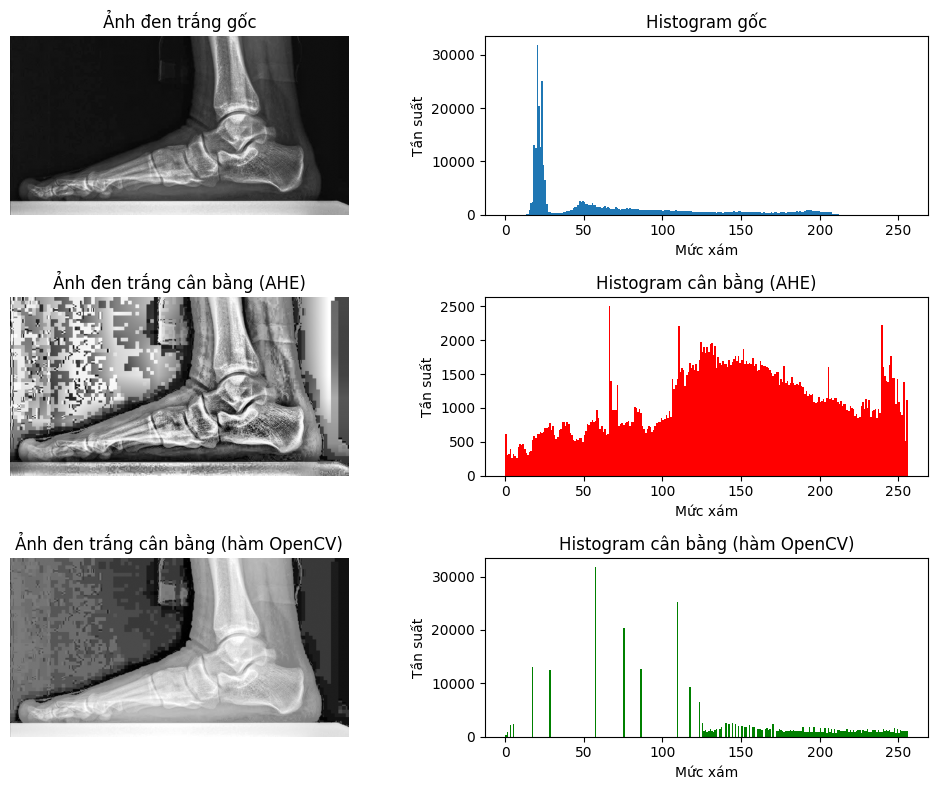

In [30]:
h_anh_can_bang2 = ahe(h_anh, grid_size=(8, 8))
hist_can_bang2 = h_anh_can_bang2.ravel()

fig, ax = plt.subplots(3, 2, figsize=(10, 8))

ax[0, 0].imshow(h_anh, cmap='gray')
ax[0, 0].set(title='Ảnh đen trắng gốc')
ax[0, 0].axis('off')

ax[0, 1].hist(hist_origin, bins=256, range=(0, 256))
ax[0, 1].set(title='Histogram gốc', xlabel='Mức xám', ylabel='Tần suất')

ax[1, 0].imshow(h_anh_can_bang2, cmap='gray')
ax[1, 0].set(title='Ảnh đen trắng cân bằng (AHE)')
ax[1, 0].axis('off')

ax[1, 1].hist(hist_can_bang2, bins=256, range=(0, 256), color='red')
ax[1, 1].set(title='Histogram cân bằng (AHE)', xlabel='Mức xám', ylabel='Tần suất')

ax[2, 0].imshow(cv2.equalizeHist(h_anh), cmap='gray')
ax[2, 0].set(title='Ảnh đen trắng cân bằng (hàm OpenCV)')
ax[2, 0].axis('off')

ax[2, 1].hist(cv2.equalizeHist(h_anh).ravel(), bins=256, range=(0, 256), color='green')
ax[2, 1].set(title='Histogram cân bằng (hàm OpenCV)', xlabel='Mức xám', ylabel='Tần suất')

plt.tight_layout()
plt.show();


In [22]:
def clip_histogram(hist, tile_size, clip_limit=2.0):
    clip_threshold = int(clip_limit * tile_size / 256)
    
    if clip_threshold <= 1:
        return hist
    
    clipped_hist = np.copy(hist)
    excess = 0
    
    for i in range(256):
        if clipped_hist[i] > clip_threshold:
            excess += clipped_hist[i] - clip_threshold
            clipped_hist[i] = clip_threshold
    
    redistribute = excess // 256
    remainder = excess % 256
    
    for i in range(256):
        clipped_hist[i] += redistribute
        if i < remainder:
            clipped_hist[i] += 1
    
    return clipped_hist

In [23]:
def clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    if len(image.shape) != 2:
        raise ValueError("Ảnh phải là ảnh xám")
    
    # Bước 1: Pad ảnh
    padded_image, pad_info = pad_image_for_tiling(image, tile_grid_size)
    
    # Bước 2: Áp dụng CLAHE trên ảnh đã pad
    height, width = padded_image.shape
    grid_rows, grid_cols = tile_grid_size
    tile_height = height // grid_rows
    tile_width = width // grid_cols
    
    # Tạo LUTs
    luts = np.zeros((grid_rows, grid_cols, 256))
    
    for i in range(grid_rows):
        for j in range(grid_cols):
            y_start = i * tile_height
            y_end = (i + 1) * tile_height
            x_start = j * tile_width
            x_end = (j + 1) * tile_width
            
            tile = padded_image[y_start:y_end, x_start:x_end]
            
            hist = compute_histogram(tile)
            hist_clipped = clip_histogram(hist, tile.size, clip_limit)
            luts[i, j] = create_lookup_table(hist_clipped)
    
    # Áp dụng interpolation
    result_padded = np.zeros_like(padded_image, dtype=np.float32)
    
    for y in range(height):
        for x in range(width):
            tile_y = (y + 0.5) / tile_height - 0.5
            tile_x = (x + 0.5) / tile_width - 0.5
            
            tile_y = np.clip(tile_y, 0, grid_rows - 1)
            tile_x = np.clip(tile_x, 0, grid_cols - 1)
            
            result_padded[y, x] = bilinear_interpolation(
                padded_image[y, x], tile_y, tile_x, luts, tile_grid_size
            )
    
    result_padded = np.clip(result_padded, 0, 255).astype(np.uint8)
    
    # Bước 3: Crop về kích thước gốc
    result = crop_padded_result(result_padded, pad_info)
        
    return result

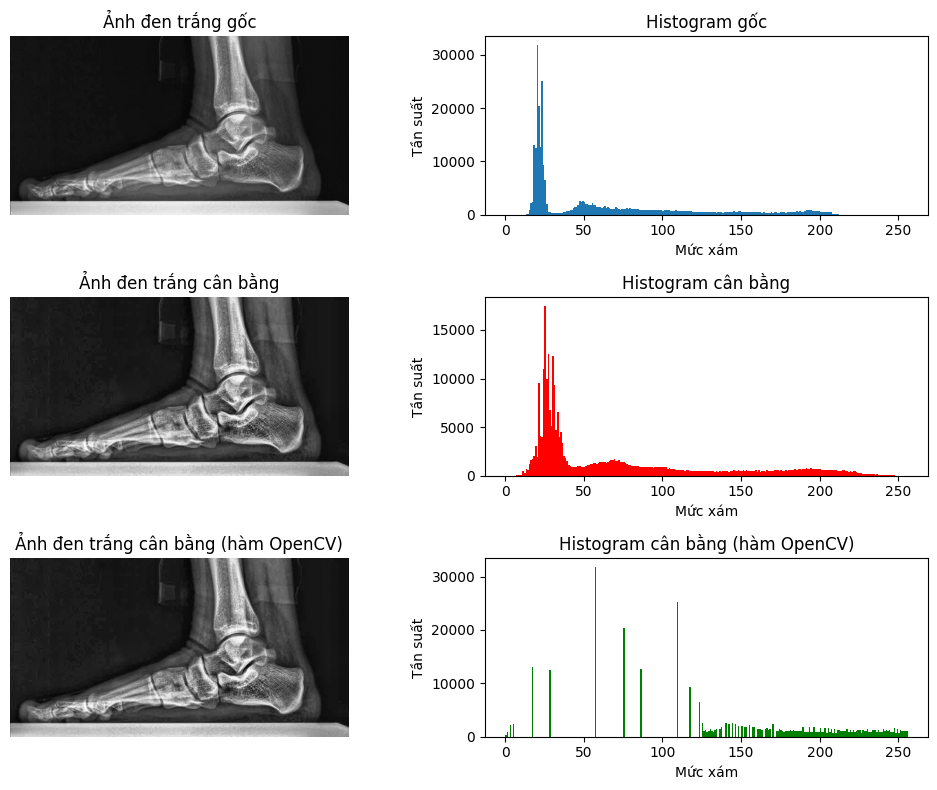

In [31]:
h_anh_can_bang3 = clahe(h_anh)
hist_can_bang3 = h_anh_can_bang3.ravel()

fig, ax = plt.subplots(3, 2, figsize=(10, 8))

# Vẽ ảnh gốc và histogram gốc
ax[0, 0].imshow(h_anh, cmap='gray')
ax[0, 0].set(title='Ảnh đen trắng gốc')
ax[0, 0].axis('off')

ax[0, 1].hist(hist_origin, bins=256, range=(0, 256))
ax[0, 1].set(title='Histogram gốc', xlabel='Mức xám', ylabel='Tần suất')

# Vẽ ảnh cân bằng và histogram cân bằng
ax[1, 0].imshow(h_anh_can_bang3, cmap='gray')
ax[1, 0].set(title='Ảnh đen trắng cân bằng')
ax[1, 0].axis('off')

ax[1, 1].hist(hist_can_bang3, bins=256, range=(0, 256), color='red')
ax[1, 1].set(title='Histogram cân bằng', xlabel='Mức xám', ylabel='Tần suất')

# Vẽ ảnh cân bằng và histogram cân bằng (hàm OpenCV)
clahe_obj = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
h_anh_can_bang3 = clahe_obj.apply(h_anh)
ax[2, 0].imshow(h_anh_can_bang3, cmap='gray')
ax[2, 0].set(title='Ảnh đen trắng cân bằng (hàm OpenCV)')
ax[2, 0].axis('off')

ax[2, 1].hist(cv2.equalizeHist(h_anh).ravel(), bins=256, range=(0, 256), color='green')
ax[2, 1].set(title='Histogram cân bằng (hàm OpenCV)', xlabel='Mức xám', ylabel='Tần suất')

plt.tight_layout()
plt.show();

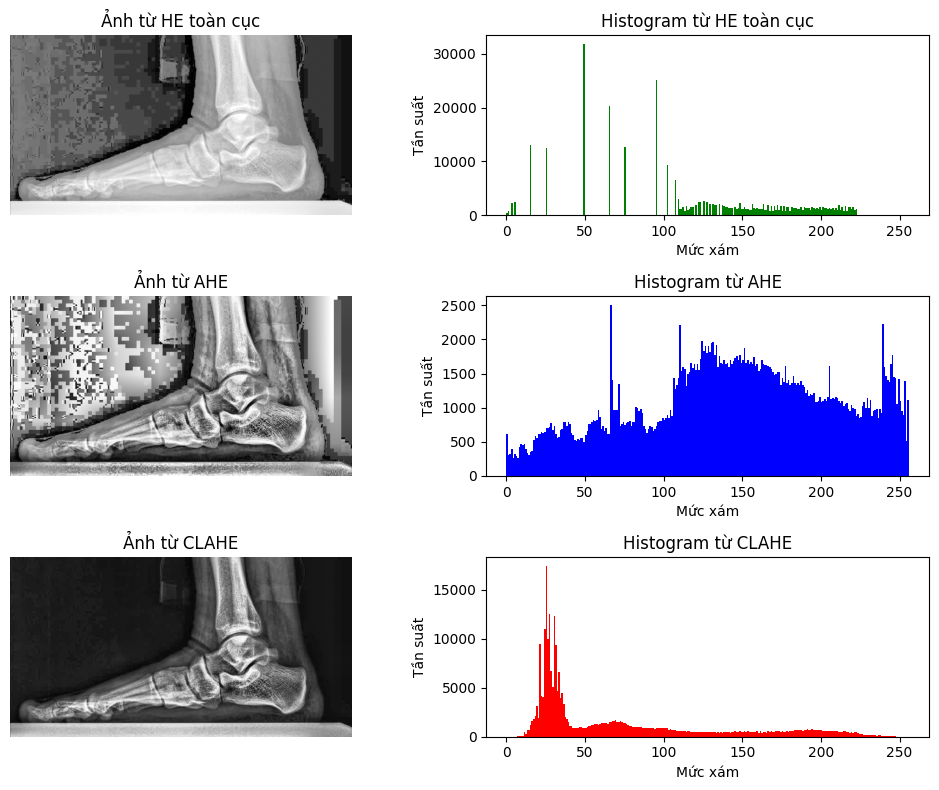

In [38]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8))

# Vẽ ảnh và histogram từ thuật toán Histogram Equalization toàn cục
ax[0, 0].imshow(h_anh_can_bang1, cmap='gray')
ax[0, 0].set(title='Ảnh từ HE toàn cục')
ax[0, 0].axis('off')

ax[0, 1].hist(hist_can_bang1, bins=256, range=(0, 256), color='green')
ax[0, 1].set(title='Histogram từ HE toàn cục', xlabel='Mức xám', ylabel='Tần suất')

# Vẽ ảnh và histogram từ thuật toán AHE
ax[1, 0].imshow(h_anh_can_bang2, cmap='gray')
ax[1, 0].set(title='Ảnh từ AHE')
ax[1, 0].axis('off')

ax[1, 1].hist(hist_can_bang2, bins=256, range=(0, 256), color='blue')
ax[1, 1].set(title='Histogram từ AHE', xlabel='Mức xám', ylabel='Tần suất')

# Vẽ ảnh và histogram từ thuật toán CLAHE 
ax[2, 0].imshow(h_anh_can_bang3, cmap='gray')
ax[2, 0].set(title='Ảnh từ CLAHE')
ax[2, 0].axis('off')

ax[2, 1].hist(hist_can_bang3, bins=256, range=(0, 256), color='red')
ax[2, 1].set(title='Histogram từ CLAHE', xlabel='Mức xám', ylabel='Tần suất')

plt.tight_layout()
plt.show();